In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import glob
import matplotlib.pyplot as plt
import multiprocessing
import geopandas as gpd
import dask_geopandas as dg

/gpfs/data1/vclgp/aghdamim/envs/env4/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# L4B

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import pyproj
from pyproj import Proj, Transformer
from rasterio.features import rasterize
from rasterio.features import geometry_mask
import multiprocessing
import matplotlib.pyplot as plt
from shapely.geometry import box, shape
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm

In [3]:
with rasterio.open('L4B/GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v5.tif') as src:
    regions = src.read(1)
    print(src.meta)

    transform = src.transform
    crs = src.crs
    
    # pixel_width = transform.a
    # pixel_height = transform.e
    # top_left_x = transform.c
    # top_left_y = transform.f
    
    # rows, cols = regions.shape
    # latitudes = np.array([[top_left_y - row * pixel_height] for row in range(rows)]).ravel()
    # longitudes = np.array([[top_left_x + col * pixel_width] for col in range(cols)]).ravel()

    # transformer = Transformer.from_proj('EPSG:6933', 'EPSG:4326')
    # lons, lats = transformer.transform(longitudes, latitudes)
    
    # # raster_array[latitudes > 50] = 0

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 34704, 'height': 14616, 'count': 1, 'crs': CRS.from_epsg(6933), 'transform': Affine(1000.8950233495561, 0.0, -17367530.4451615,
       0.0, -1000.895023349556, 7314540.8306386)}


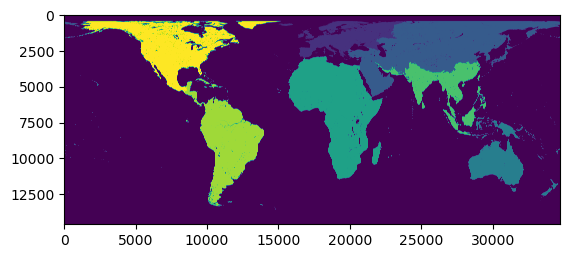

In [4]:
plt.imshow(regions)

[0 1 2 3 4 5 6 7]


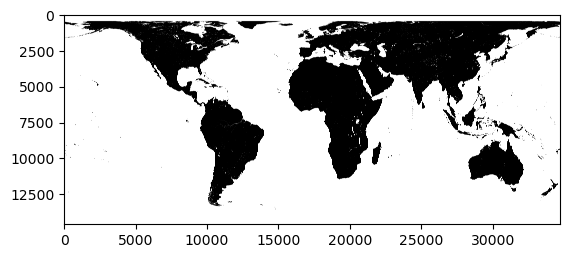

In [5]:
mask1 = regions==0
print(np.unique(regions))
plt.imshow(mask1, cmap='gray')

In [6]:
with rasterio.open('L4B/GEDI_L4B_Gridded_Biomass_V2_1_2299/data/GEDI04_B_MW019MW223_02_002_02_R01000M_MU.tif') as src:
    data = src.read(1)
    metadata = src.meta.copy()
    transform = src.transform
    print(metadata)
    rows, cols = src.height, src.width

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 34704, 'height': 14616, 'count': 1, 'crs': CRS.from_epsg(6933), 'transform': Affine(1000.8950233496674, 0.0, -17367530.4451615,
       0.0, -1000.8950233496674, 7314540.8306386)}


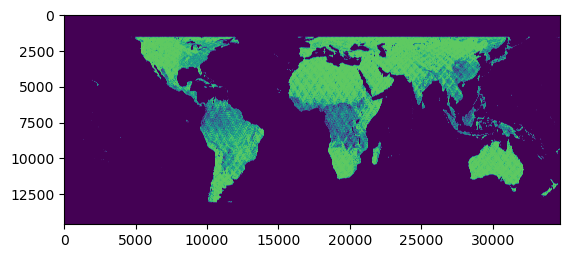

In [7]:
plt.imshow(data)

In [14]:
col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

def run_parallel(i):
    x, y = rasterio.transform.xy(transform, row_indices[i], col_indices[i], offset='center')
    return {f'{i}': [x, y]}

coords = {}
n_cpus = 30
pool = multiprocessing.Pool(n_cpus)
for output in tqdm(pool.imap_unordered(run_parallel, list(range(rows))), total=rows, position=0):
    coords.update(output)
pool.close()

100%|█████████████████████████████████████████████| 14616/14616 [07:09<00:00, 34.00it/s]


In [67]:
# x_coords = []
# y_coords = []
# for i in range(rows):
#     x_coords.append(coords[f'{i}'][0])
#     y_coords.append(coords[f'{i}'][1])

# x_coords = np.array(x_coords)
# y_coords = np.array(y_coords)

# np.save('L4B/x_coords.npy', x_coords)
# np.save('L4B/y_coords.npy', y_coords)

In [2]:
x_coords = np.load('L4B/x_coords.npy')
y_coords = np.load('L4B/y_coords.npy')

In [8]:
crs_from = pyproj.CRS.from_epsg(6933)  # EPSG:6933
crs_to = pyproj.CRS.from_epsg(4326)    # EPSG:4326

transformer = pyproj.Transformer.from_crs(crs_from, crs_to, always_xy=True)

lon, lat = transformer.transform(x_coords, y_coords)

In [9]:
mask2 = np.logical_and(lat>-51.6, lat<51.6)

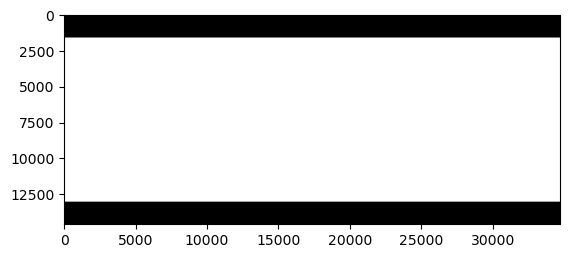

In [10]:
plt.imshow(mask2, cmap='gray')

In [11]:
gap = (data==-9999.0).astype('uint8')
gap[mask1] = 0
gap[~mask2] = 0
gap[gap==1] = 255

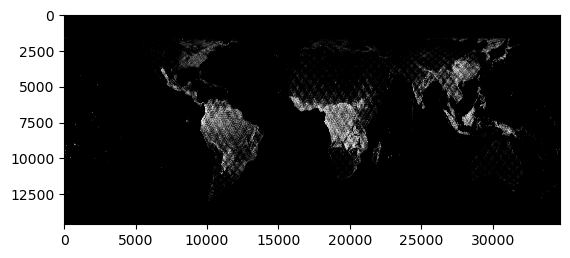

In [12]:
plt.imshow(gap, cmap='gray')

In [100]:
metadata2 = metadata.copy()
metadata2.update(dtype=rasterio.uint8)
metadata2.update(nodata=0)

with rasterio.open('L4B/gap_final.tif', 'w', **metadata2) as dst:
    dst.write(gap, 1)

# make hex shapefile

In [26]:
import h3
import geopandas as gpd
from shapely.geometry import Polygon, Point
from collections import Counter
from shapely.geometry import Polygon, LineString
from shapely.ops import split
import fiona
from fiona.crs import from_epsg

In [14]:
with rasterio.open('L4B/gap_final.tif') as src:
    gap = src.read(1).astype('bool')

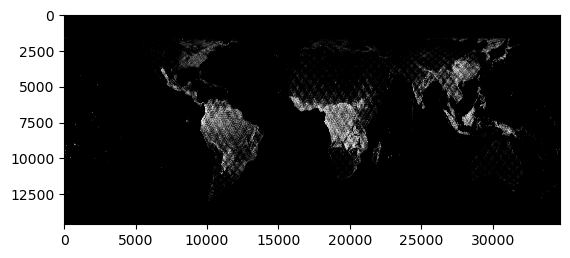

In [15]:
plt.imshow(gap, cmap='gray')

In [16]:
x_coords = np.load('L4B/x_coords.npy')
y_coords = np.load('L4B/y_coords.npy')

In [17]:
crs_from = pyproj.CRS.from_epsg(6933)  # EPSG:6933
crs_to = pyproj.CRS.from_epsg(4326)    # EPSG:4326

transformer = pyproj.Transformer.from_crs(crs_from, crs_to, always_xy=True)

lons, lats = transformer.transform(x_coords, y_coords)

In [18]:
gap_lons = lons[gap]
gap_lats = lats[gap]

In [22]:
gap_points = []
for (lon, lat) in tqdm(zip(gap_lons, gap_lats), position=0, total=len(gap_lats)):
    gap_points.append(Point(lon, lat))

100%|███████| 14340858/14340858 [02:01<00:00, 118331.69it/s]


In [27]:
schema = {
    'geometry': 'Point',
    'properties': {},
}

with fiona.open(f'L4B/gap_shp/gap_coords.shp', 'w', driver='ESRI Shapefile', schema=schema, crs=from_epsg(4326)) as shp:
    for gap_point in tqdm(gap_points, position=0, total=len(gap_points)):
        shp.write({
            'geometry': mapping(gap_point),
            'properties': {},
        })

100%|████████| 14340858/14340858 [19:27<00:00, 12284.37it/s]


In [146]:
# Define the desired resolution (0 to 15)
resolution = 7

# Convert coordinates to H3 indices
h3_indices = []
for (lat, lng) in tqdm(zip(gap_lats, gap_lons), total=len(gap_lons), position=0):
    h3_indices.append(h3.geo_to_h3(lat, lng, resolution))

hex_counts = Counter(h3_indices)

100%|████████████████████████████████████████| 14340858/14340858 [00:28<00:00, 501562.23it/s]


In [147]:
hex_geometries = []
hex_values = []
for hex_id, count in tqdm(hex_counts.items(), position=0, total=len(hex_counts)):
    # Get the boundary of the hexagon
    hex_boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    # Convert to shapely Polygon
    polygon = Polygon(hex_boundary)
    if polygon.bounds[0]*polygon.bounds[2]<0 and np.abs(polygon.bounds[0])>170:
        pass
    else:
        hex_geometries.append(polygon)
        hex_values.append(count)

100%|███████████████████████████████████████████| 4847721/4847721 [04:55<00:00, 16414.27it/s]


In [148]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': hex_geometries, 'count': hex_values})

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

print(gdf['count'].max())
print(gdf['count'].min())

# # # Save the GeoDataFrame to a shapefile
# gdf.to_file(f'L4B/gap_shp/gap_map_res{resolution}.shp')

8
1


In [149]:
schema = {
    'geometry': 'Polygon',
    'properties': {'count': 'int'},
}

with fiona.open(f'L4B/gap_shp/gap_map_res{resolution}.shp', 'w', driver='ESRI Shapefile', schema=schema, crs=gdf.crs) as shp:
    for i, row in enumerate(tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Writing shapefile")):
        shp.write({
            'geometry': mapping(row[1].geometry),
            'properties': row[1].drop('geometry').to_dict(),
        })

Writing shapefile: 100%|█████████████████████████| 4847669/4847669 [48:55<00:00, 1651.59it/s]


# histogram

In [119]:
resolution = 3
gdf = gpd.read_file(f'L4B/gap_shp/gap_map_res{resolution}.shp')
gdf_proj = gdf.copy()
gdf_proj = gdf_proj.to_crs(epsg=6933)

In [120]:
print(gdf_proj['count'].min())
print(gdf_proj['count'].max())

1
12334


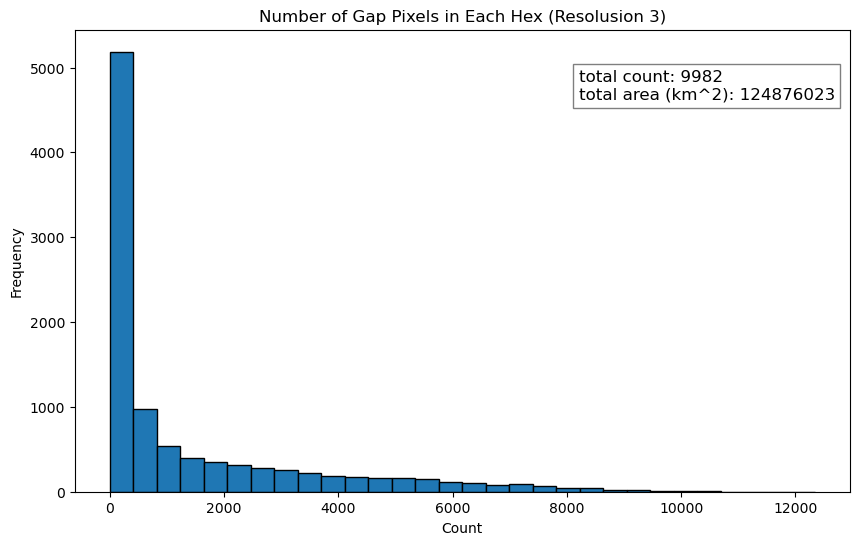

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(gdf['count'].dropna(), bins=30, edgecolor='black')
ax.set_title(f'Number of Gap Pixels in Each Hex (Resolusion {resolution})')
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')

textstr = 'total count: {}\ntotal area (km^2): {}'.format(len(gdf_proj), int(gdf_proj['geometry'].area.sum()/1000000))
ax.text(0.65, 0.85, textstr, transform=ax.transAxes, fontsize=12, 
        bbox=dict(facecolor='white', alpha=0.5))

plt.savefig(f'L4B/hists/hist_res{resolution}', dpi=300) 
plt.show()